# Curly Vector Calculation Demo
---
by Yitao LIU 2025-07

This notebook demonstrates how bidirectional curly vector length and direction are calculated,
with exaggerated scaling to help visualize the process.

**Bidirectional Curly Vectors:**
- Grid points are positioned at the CENTER of each vector
- Equal forward and backward integration from each grid point
- Provides balanced view of flow patterns around measurement locations

mail: liuyitao97@outlook.com

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append('../')  # Adjust path to include the parent directory
from curlyvector import curly_vector_plot, curly_vector_key
import matplotlib.patches as patches

## Load Sample Data
First, let's load the same wind data used in the main example.

In [2]:
# Load the sample dataset
ds = xr.open_dataset('../data/SampleData_curly_vector_NCEP_ltm_uv850hPa_JJA_AsiaMonsoon.nc')
lon = ds['lon'].values
lat = ds['lat'].values
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Convert xarray DataArrays to numpy arrays
u_data = ds['u'].values
v_data = ds['v'].values

print(f"Data shape: {u_data.shape}")
print(f"Longitude range: {lon.min():.1f} to {lon.max():.1f}")
print(f"Latitude range: {lat.min():.1f} to {lat.max():.1f}")
print(f"U wind range: {u_data.min():.2f} to {u_data.max():.2f} m/s")
print(f"V wind range: {v_data.min():.2f} to {v_data.max():.2f} m/s")

Data shape: (31, 37)
Longitude range: 55.0 to 145.0
Latitude range: -15.0 to 60.0
U wind range: nan to nan m/s
V wind range: nan to nan m/s


## Step 1: Understanding Bidirectional Curly Vectors

Curly vectors provide an elegant way to visualize vector fields where:

### Grid Point Positioning
- **Grid points are at the CENTER** of each vector arrow
- **Forward integration**: From grid point in the flow direction (length/2)
- **Backward integration**: From grid point against the flow direction (length/2)
- **Total length**: Proportional to vector magnitude (scale × speed)

### Key Advantages
1. **Balanced representation**: Shows flow context around measurement points
2. **Clearer visualization**: Reduces overlap in dense vector fields  
3. **Better interpretation**: Easier to understand local flow patterns

Let's examine how this works step by step.

In [3]:
# Select a small region for detailed analysis
lat_idx = slice(20, 30)  # Select a 10x10 region
lon_idx = slice(20, 30)

# Extract small region
lon_small = lon_grid[lat_idx, lon_idx]
lat_small = lat_grid[lat_idx, lon_idx]
u_small = u_data[lat_idx, lon_idx]
v_small = v_data[lat_idx, lon_idx]

# Calculate wind speed and direction
wind_speed = np.sqrt(u_small**2 + v_small**2)
wind_direction = np.arctan2(v_small, u_small) * 180 / np.pi  # Convert to degrees

print(f"Small region shape: {u_small.shape}")
print(f"Wind speed range: {np.nanmin(wind_speed):.2f} to {np.nanmax(wind_speed):.2f} m/s")
print(f"Wind direction range: {np.nanmin(wind_direction):.1f} to {np.nanmax(wind_direction):.1f} degrees")

Small region shape: (10, 10)
Wind speed range: 0.04 to 3.32 m/s
Wind direction range: -130.6 to 177.6 degrees


## Step 2: Visualizing Raw Vector Components

Let's first show the raw U and V components as a heatmap to understand the data structure.

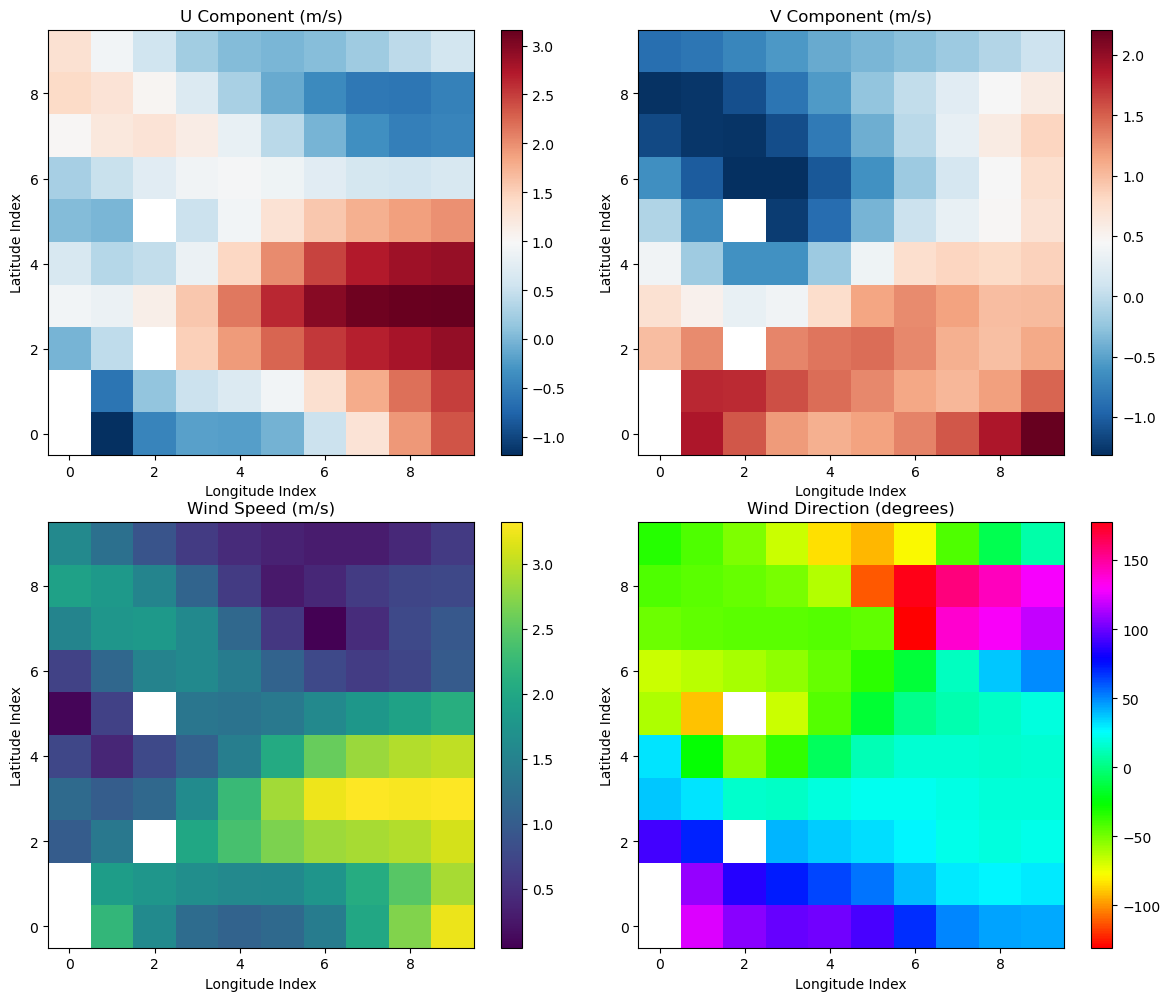

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# U component
im1 = axes[0,0].imshow(u_small, cmap='RdBu_r', origin='lower')
axes[0,0].set_title('U Component (m/s)')
axes[0,0].set_xlabel('Longitude Index')
axes[0,0].set_ylabel('Latitude Index')
plt.colorbar(im1, ax=axes[0,0])

# V component
im2 = axes[0,1].imshow(v_small, cmap='RdBu_r', origin='lower')
axes[0,1].set_title('V Component (m/s)')
axes[0,1].set_xlabel('Longitude Index')
axes[0,1].set_ylabel('Latitude Index')
plt.colorbar(im2, ax=axes[0,1])

# Wind speed
im3 = axes[1,0].imshow(wind_speed, cmap='viridis', origin='lower')
axes[1,0].set_title('Wind Speed (m/s)')
axes[1,0].set_xlabel('Longitude Index')
axes[1,0].set_ylabel('Latitude Index')
plt.colorbar(im3, ax=axes[1,0])

# Wind direction
im4 = axes[1,1].imshow(wind_direction, cmap='hsv', origin='lower')
axes[1,1].set_title('Wind Direction (degrees)')
axes[1,1].set_xlabel('Longitude Index')
axes[1,1].set_ylabel('Latitude Index')
plt.colorbar(im4, ax=axes[1,1])

plt.tight_layout()
plt.show()

## Step 3: Vector Length and Scaling Effects

The curly vector length is determined by the wind speed magnitude and scaling factor. 
Let's demonstrate how different scaling factors affect the bidirectional visualization.

Demo region shape: (4, 4)


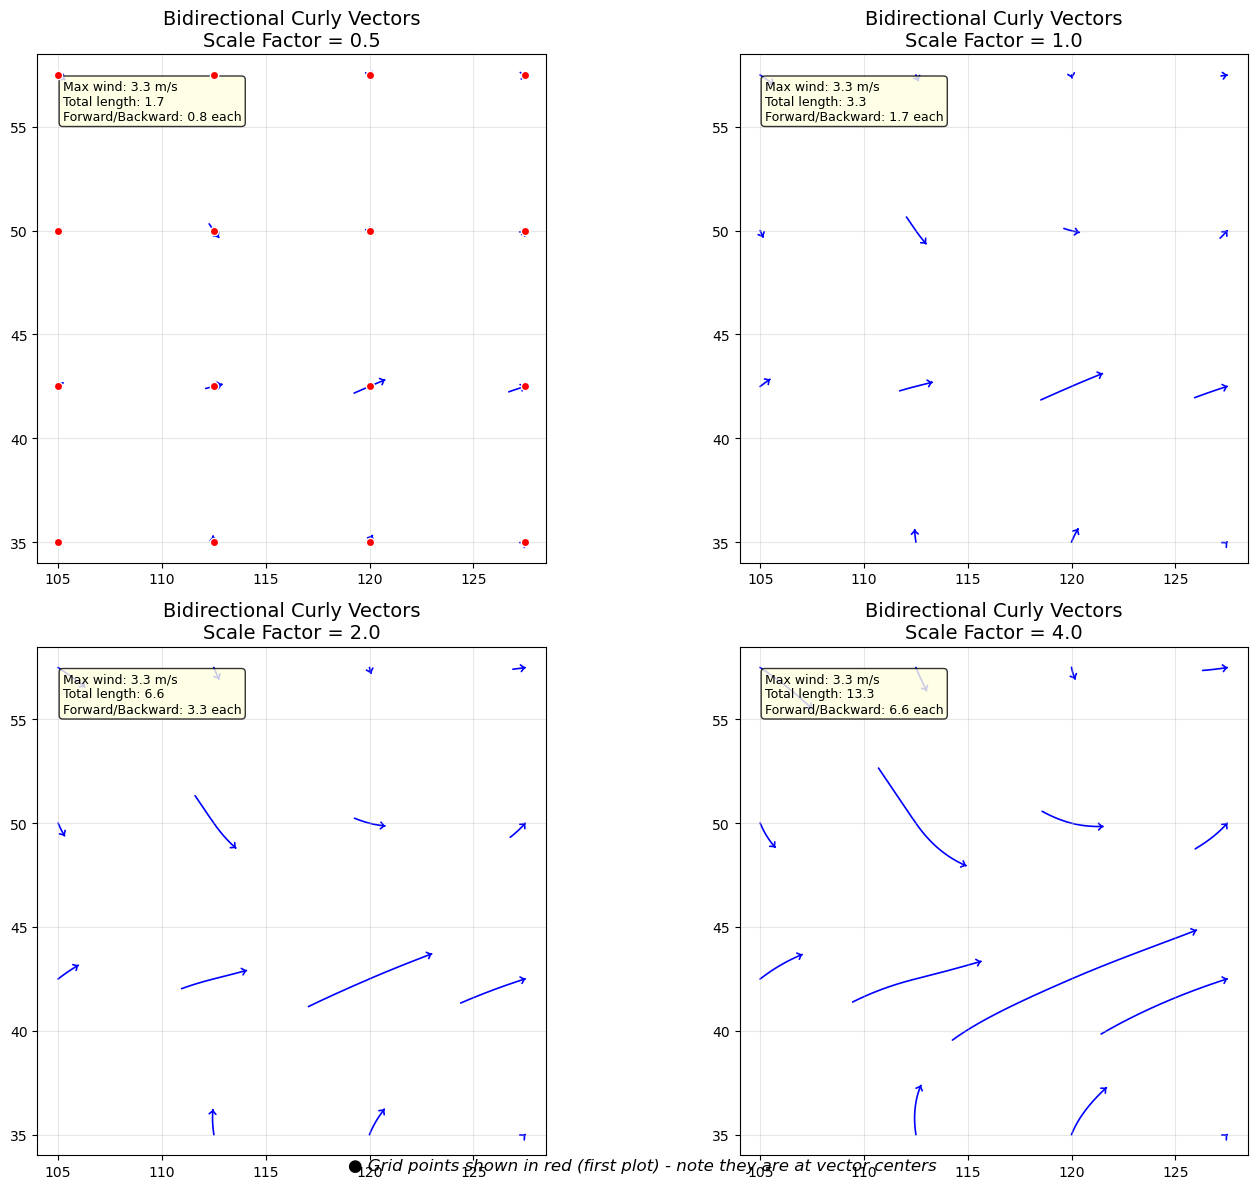

In [5]:
# Use an even smaller region for clearer visualization
step = 3
lon_demo = lon_small[::step, ::step]
lat_demo = lat_small[::step, ::step]
u_demo = u_small[::step, ::step]
v_demo = v_small[::step, ::step]

print(f"Demo region shape: {u_demo.shape}")

# Different scaling factors to demonstrate length calculation
scales = [0.5, 1.0, 2.0, 4.0]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, scale in enumerate(scales):
    ax = axes[i]
    
    # Set up the plot
    ax.set_title(f'Bidirectional Curly Vectors\nScale Factor = {scale}', fontsize=14)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Plot curly vectors with different scales
    params = {'head_length': 0.4, 'head_width': 0.08, 'linewidth': 1.2, 
              'scale': scale, 'color': 'blue'}
    
    curly_vector_plot(ax, lon_demo, lat_demo, u_demo, v_demo, 
                      transform=None, **params)
    
    # Mark a few grid points to show center positioning
    if i == 0:  # Only show on first plot to avoid clutter
        for ii in range(0, lon_demo.shape[0], 1):
            for jj in range(0, lon_demo.shape[1], 1):
                ax.plot(lon_demo[ii, jj], lat_demo[ii, jj], 'ro', 
                       markersize=6, markerfacecolor='red', 
                       markeredgecolor='white', markeredgewidth=1, zorder=10)
    
    # Add reference scale and calculation info
    max_wind = np.nanmax(np.sqrt(u_demo**2 + v_demo**2))
    total_length = max_wind * scale
    half_length = total_length / 2
    
    info_text = f'Max wind: {max_wind:.1f} m/s\n'
    info_text += f'Total length: {total_length:.1f}\n'
    info_text += f'Forward/Backward: {half_length:.1f} each'
        
    ax.text(0.05, 0.95, info_text, 
            transform=ax.transAxes, fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            verticalalignment='top')
    
    ax.set_xlim(np.nanmin(lon_demo) - 1, np.nanmax(lon_demo) + 1)
    ax.set_ylim(np.nanmin(lat_demo) - 1, np.nanmax(lat_demo) + 1)

# Add explanation for grid point markers
fig.text(0.5, 0.02, '● Grid points shown in red (first plot) - note they are at vector centers', 
         ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.show()